# Customer Lifetime Value Prediction

This notebook contains the process for training and creating a pipeline to predict customer lifetime value and to segment customers

In [1]:
#Import the neccesary libraries
import warnings
warnings.filterwarnings('ignore')
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

In [2]:
#Import and preprocess dataset
df = pd.read_csv("uk_dataset_full.csv")
df.columns = df.columns.str.replace(' ', '')
df.rename(columns={"Price":"UnitPrice"},inplace=True)
df.head(5)

,Unnamed:0,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
#Remove return orders and cancelled orders
# Handling Return Orders
# Extracting rows where InvoiceNo starts with "C"
data_raw = df.copy()
cancelled_orders = data_raw[data_raw['Invoice'].astype(str).str.startswith("C")]

# Create a temporary DataFrame with the columns we want to match on, and also negate the 'Quantity' column
cancelled_orders['Quantity'] = -cancelled_orders['Quantity']

# Merge the original DataFrame with the temporary DataFrame on the columns we want to match
merged_data = pd.merge(data_raw, cancelled_orders[['CustomerID', 'StockCode', 'Quantity', 'UnitPrice']], 
                       on=['CustomerID', 'StockCode', 'Quantity', 'UnitPrice'], 
                       how='left', indicator=True)

# Filter out rows where the merge found a match, and also filter out the original return orders
data_raw = merged_data[(merged_data['_merge'] == 'left_only') & (~merged_data['Invoice'].astype(str).str.startswith("C"))]

# Drop the indicator column
data_raw = data_raw.drop(columns=['_merge'])

# Selecting relevant features and calculating total sales
features = ['CustomerID', 'Invoice', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country']
data = data_raw[features]
data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])

# Removing transactions with missing customer IDs as they don't contribute to individual customer behavior
data = data[data['CustomerID'].notna()]
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)
data.head()

,CustomerID,Invoice,InvoiceDate,Quantity,UnitPrice,Country,TotalSales
0,13085,489434,2009-12-01 07:45:00,12,6.95,United Kingdom,83.4
1,13085,489434,2009-12-01 07:45:00,12,6.75,United Kingdom,81.0
2,13085,489434,2009-12-01 07:45:00,12,6.75,United Kingdom,81.0
3,13085,489434,2009-12-01 07:45:00,48,2.10,United Kingdom,100.8
4,13085,489434,2009-12-01 07:45:00,24,1.25,United Kingdom,30.0


In [11]:
from lifetimes import GammaGammaFitter
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.utils import summary_data_from_transaction_data

# create summary data from transaction data
summary = summary_data_from_transaction_data(data, 
                                             customer_id_col = 'CustomerID', 
                                             datetime_col = 'InvoiceDate', 
                                             monetary_value_col='TotalSales',
                                             observation_period_end = max(df["InvoiceDate"]))

summary = summary[summary["monetary_value"] > 0]

# fit the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# fit the Gamma-Gamma submodel
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(summary['frequency'], summary['monetary_value'])


# predict customer lifetime value
summary['predicted_purchases'] = bgf.predict(30, summary['frequency'], summary['recency'], summary['T'])
summary['predicted_clv'] = ggf.customer_lifetime_value(bgf, 
                                                       summary['frequency'],
                                                       summary['recency'],
                                                       summary['T'],
                                                       summary['monetary_value'],
                                                       time=1, #the lifetime expected for the user in months
                                                       freq='D', 
                                                       discount_rate=0.01)
# Calculate the probability that a customer is alive
summary['probability_alive'] = bgf.conditional_probability_alive(
    summary['frequency'], 
    summary['recency'], 
    summary['T']
)
summary["estimated_monetary_value"] = ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    )
summary.head()

,frequency,recency,T,monetary_value,predicted_purchases,predicted_clv,probability_alive,estimated_monetary_value
CustomerID,,,,,,,,
12346,7.0,400.0,725.0,11066.637143,0.151909,1431.931083,0.493155,9520.529482
12347,7.0,402.0,404.0,717.398571,0.494234,329.199287,0.984980,672.740683
12348,4.0,363.0,438.0,449.310000,0.288289,125.652064,0.945105,440.212758
12349,3.0,571.0,589.0,1120.056667,0.188502,171.430749,0.963455,918.531323
12352,8.0,356.0,392.0,338.261250,0.559256,192.407218,0.974185,347.481829


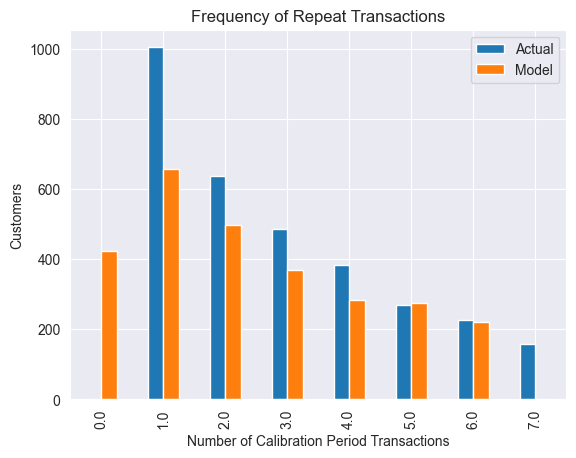

In [12]:
from lifetimes.plotting import plot_period_transactions

# Plot the expected number of transactions in future periods
plot_period_transactions(bgf);

In [6]:
print("Merged max :",  df["InvoiceDate"].max())
print("Merged min :",  df["InvoiceDate"].min())

Merged max : 2011-12-09 12:50:00
Merged min : 2009-12-01 07:45:00


In [5]:
df.head()

,Unnamed:0,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [14]:
from lifetimes.utils import calibration_and_holdout_data
import pandas as pd

# Define the calibration period end date
calibration_period_end = pd.to_datetime('2011-05-31')

# Create the holdout data
holdout_summary = calibration_and_holdout_data(
    data,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalSales',
    calibration_period_end=calibration_period_end,
    observation_period_end=pd.to_datetime('2011-12-09')
)

# Filter out rows with negative or zero monetary value in the calibration period
holdout_summary = holdout_summary[holdout_summary['monetary_value_cal'] > 0]

# Fit the model on calibration data
bgf.fit(holdout_summary['frequency_cal'], holdout_summary['recency_cal'], holdout_summary['T_cal'])

# Fit the Gamma-Gamma model on calibration data
ggf.fit(holdout_summary['frequency_cal'], holdout_summary['monetary_value_cal'])


<lifetimes.GammaGammaFitter: fitted with 3307 subjects, p: 2.32, q: 3.53, v: 458.67>

In [17]:
from sklearn.metrics import roc_auc_score, mean_absolute_error

# Predict CLV in the holdout period
holdout_summary['predicted_clv'] = ggf.customer_lifetime_value(bgf, 
                                                               holdout_summary['frequency_cal'],
                                                               holdout_summary['recency_cal'],
                                                               holdout_summary['T_cal'],
                                                               holdout_summary['monetary_value_cal'],
                                                               time=1, 
                                                               freq='D', 
                                                               discount_rate=0.01)

# Calculate error metrics for CLV
actual_revenue = holdout_summary['monetary_value_holdout']
predicted_clv = holdout_summary['predicted_clv']
mae_clv = mean_absolute_error(actual_revenue, predicted_clv)
rmse_clv = np.sqrt(mean_squared_error(actual_revenue, predicted_clv))
print(f"CLV - MAE: {mae_clv}, RMSE: {rmse_clv}")

# Calculate the probability that customers are still alive in the holdout period
holdout_summary['probability_alive_holdout'] = bgf.conditional_probability_alive(
    holdout_summary['frequency_holdout'], 
    holdout_summary['recency_holdout'], 
    holdout_summary['T_holdout']
)

# Create a binary column 'is_alive' based on whether the customer made a purchase in the holdout period
holdout_summary['is_alive'] = holdout_summary['frequency_holdout'] > 0

# Calculate ROC AUC for probability of being alive
roc_auc = roc_auc_score(holdout_summary['is_alive'], holdout_summary['probability_alive_holdout'])
print(f"ROC AUC for probability of being alive: {roc_auc}")

# Plot the frequency-recency matrix
plot_frequency_recency_matrix(bgf)
plt.show()

CLV - MAE: 159.4538889378756, RMSE: 599.4483605734412


KeyError: 'recency_holdout'

Index(['frequency_cal', 'recency_cal', 'T_cal', 'monetary_value_cal',
       'frequency_holdout', 'monetary_value_holdout', 'duration_holdout'],
      dtype='object')
Purchases - MAE: 1.7001853542725647, RMSE: 3.463586456304757, MAPE: 284487200654343.56
CLV - MAE: 155.60833810350903, RMSE: 604.7167607960554, MAPE: 1.0837291449052784e+17
Holdout columns for frequency, recency, and T are not available.


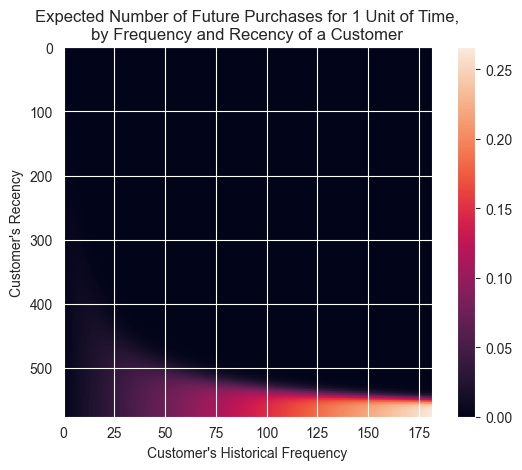

In [20]:
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_frequency_recency_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# Define the calibration and holdout periods
calibration_period_end = '2011-06-30'  # Adjust this date based on your dataset

# Generate calibration and holdout data
holdout_summary = calibration_and_holdout_data(data, 
                                               customer_id_col='CustomerID', 
                                               datetime_col='InvoiceDate', 
                                               monetary_value_col='TotalSales',
                                               calibration_period_end=calibration_period_end,
                                               observation_period_end='2011-12-09')

# Check the columns of holdout_summary to understand the structure
print(holdout_summary.columns)

# Filter out rows with negative or zero monetary value
holdout_summary = holdout_summary[holdout_summary["monetary_value_cal"] > 0]

# Fit the BG/NBD model on the calibration data
bgf.fit(holdout_summary['frequency_cal'], holdout_summary['recency_cal'], holdout_summary['T_cal'])

# Predict purchases in the holdout period
holdout_summary['predicted_purchases_holdout'] = bgf.predict(30, 
                                                             holdout_summary['frequency_cal'], 
                                                             holdout_summary['recency_cal'], 
                                                             holdout_summary['T_cal'])

# Calculate error metrics for purchases
mae_purchases = mean_absolute_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases_holdout'])
rmse_purchases = np.sqrt(mean_squared_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases_holdout']))
mape_purchases = mean_absolute_percentage_error(holdout_summary['frequency_holdout'], holdout_summary['predicted_purchases_holdout'])
print(f"Purchases - MAE: {mae_purchases}, RMSE: {rmse_purchases}, MAPE: {mape_purchases}")

# Fit the Gamma-Gamma model on the calibration data
ggf.fit(holdout_summary['frequency_cal'], holdout_summary['monetary_value_cal'])

# Predict CLV in the holdout period
holdout_summary['predicted_clv'] = ggf.customer_lifetime_value(bgf, 
                                                               holdout_summary['frequency_cal'],
                                                               holdout_summary['recency_cal'],
                                                               holdout_summary['T_cal'],
                                                               holdout_summary['monetary_value_cal'],
                                                               time=1, 
                                                               freq='D', 
                                                               discount_rate=0.01)

# Calculate error metrics for CLV
actual_revenue = holdout_summary['monetary_value_holdout']
predicted_clv = holdout_summary['predicted_clv']
mae_clv = mean_absolute_error(actual_revenue, predicted_clv)
rmse_clv = np.sqrt(mean_squared_error(actual_revenue, predicted_clv))
mape_clv = mean_absolute_percentage_error(actual_revenue, predicted_clv)
print(f"CLV - MAE: {mae_clv}, RMSE: {rmse_clv}, MAPE: {mape_clv}")

# Calculate the probability that customers are still alive in the holdout period
# Ensure that columns exist for frequency_holdout, recency_holdout, and T_holdout
if 'frequency_holdout' in holdout_summary.columns and 'recency_holdout' in holdout_summary.columns and 'T_holdout' in holdout_summary.columns:
    holdout_summary['probability_alive_holdout'] = bgf.conditional_probability_alive(
        holdout_summary['frequency_holdout'], 
        holdout_summary['recency_holdout'], 
        holdout_summary['T_holdout']
    )

    # Create a binary column 'is_alive' based on whether the customer made a purchase in the holdout period
    holdout_summary['is_alive'] = holdout_summary['frequency_holdout'] > 0

    # Calculate ROC AUC for probability of being alive
    roc_auc = roc_auc_score(holdout_summary['is_alive'], holdout_summary['probability_alive_holdout'])
    print(f"ROC AUC for probability of being alive: {roc_auc}")
else:
    print("Holdout columns for frequency, recency, and T are not available.")

# Plot the frequency-recency matrix
plot_frequency_recency_matrix(bgf)
plt.show()


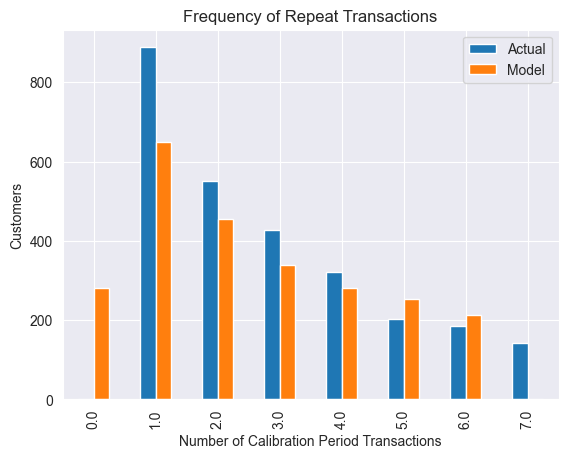

In [23]:
plot_period_transactions(bgf);
